In [1]:
!pip install timm einops


## Download DTD dataset

In [41]:
!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz

!tar -xf dtd-r1.0.1.tar.gz > /dev/null 2>&1
print("Extraction Complete!")



--2026-01-07 14:41:02--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz [following]
--2026-01-07 14:41:03--  https://thor.robots.ox.ac.uk/dtd/dtd-r1.0.1.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/octet-stream]
Saving to: ‘dtd-r1.0.1.tar.gz.1’

dtd-r1.0.1.tar.gz.1 100%[===================>] 596.27M  8.83MB/s    in 1m 47s  

2026-01-07 14:42:51 (5.55 MB/s) - ‘dtd-r1.0.1.tar.gz.1’ saved [625239812/625239812]

Extraction Complete!


In [3]:
import torch, timm, cv2, numpy as np, matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


## Dataset Loader

In [4]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder("dtd/images", transform=transform)
loader = DataLoader(train_ds, batch_size=32, shuffle=True)
num_classes = len(train_ds.classes)
print("Classes:", num_classes)


Classes: 47


## DeiT-Tiny (Vision Transformer)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'mps' if torch.backends.mps.is_available() else 'cpu'

model = timm.create_model('deit_tiny_patch16_224', pretrained=True, num_classes=num_classes)
model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=3e-4)
loss_fn = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

In [6]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=d4b5a9a2263e93a2b79b193b4748b5d222c803b1c9a7878bb14a86513ab61048
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


## ResNet18 (CNN Baseline)

In [7]:
import torchvision.models as models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch.nn as nn
cnn = models.resnet50(pretrained=True)
cnn.fc = nn.Linear(cnn.fc.in_features, num_classes)
cnn.to(device)

opt_cnn = torch.optim.Adam(cnn.parameters(), lr=3e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 73.7MB/s]


In [8]:
model.eval()
attn_weights = []

def attn_hook(module, input, output):
    attn_weights.append(output.detach())

for blk in model.blocks:
    blk.attn.attn_drop.register_forward_hook(attn_hook)


## Training

In [9]:
for epoch in range(5):
    model.train()
    cnn.train()

    vit_loss, cnn_loss = 0,0

    for x,y in loader:
        x,y = x.to(device), y.to(device)

        # ---- ViT ----
        opt.zero_grad()
        lv = loss_fn(model(x), y)
        lv.backward()
        opt.step()
        vit_loss += lv.item()

        # ---- CNN ----
        opt_cnn.zero_grad()
        lc = loss_fn(cnn(x), y)
        lc.backward()
        opt_cnn.step()
        cnn_loss += lc.item()

    print(f"Epoch {epoch+1}  ViT:{vit_loss/len(loader):.4f}  CNN:{cnn_loss/len(loader):.4f}")


Epoch 1  ViT:2.2237  CNN:2.1974
Epoch 2  ViT:1.3144  CNN:1.5209
Epoch 3  ViT:0.8785  CNN:1.2233
Epoch 4  ViT:0.6353  CNN:0.9808
Epoch 5  ViT:0.4646  CNN:0.7878


In [10]:
target_layer = cnn.layer4[-1]
cam = GradCAM(model=cnn, target_layers=[target_layer])


## Patch ViT Attention

In [11]:
import types

def patch_attention(model):
    for blk in model.blocks:
        attn = blk.attn

        def forward_with_attn(self, x, attn_mask=None):
            B, N, C = x.shape
            qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
            q, k, v = qkv.permute(2,0,3,1,4)

            attn_scores = (q @ k.transpose(-2, -1)) * self.scale
            if attn_mask is not None:
                attn_scores += attn_mask

            attn = attn_scores.softmax(dim=-1)
            self.last_attn = attn

            x = (attn @ v).transpose(1,2).reshape(B,N,C)
            x = self.proj(x)
            return self.proj_drop(x)

        attn.forward = types.MethodType(forward_with_attn, attn)


In [12]:
patch_attention(model)


In [13]:
def extract_attention(model,x):
    with torch.no_grad():
        model(x)
    return [blk.attn.last_attn for blk in model.blocks]


## ViT Attention Rollout

In [14]:
def attention_rollout(attns):
    R = torch.eye(attns[0].size(-1)).to(attns[0].device)

    for attn in attns:
        attn = attn.mean(1)
        attn = attn + torch.eye(attn.size(-1)).to(attn.device)
        attn = attn / attn.sum(dim=-1, keepdim=True)
        R = torch.matmul(attn, R)

    return R


## Visualization


Texture class: blotchy


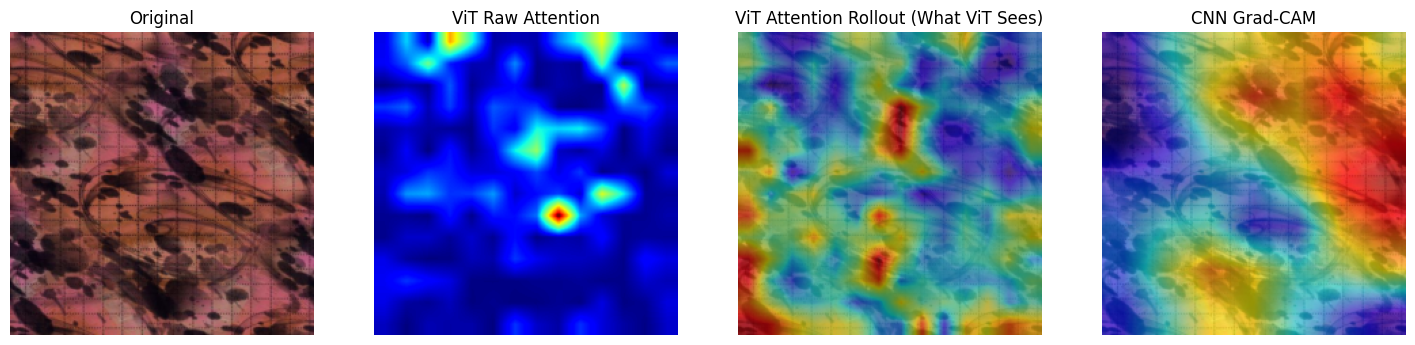

In [40]:
import cv2, matplotlib.pyplot as plt
import numpy as np, random


idx = random.randint(0, len(train_ds)-1)
img, label = train_ds[idx]
print("Texture class:", train_ds.classes[label])

x = img.unsqueeze(0).to(device)
img_np = img.permute(1,2,0).cpu().numpy()

# ---------- ViT RAW ATTENTION MAP ----------
attns = extract_attention(model, x)
raw_attn = attns[-1].mean(1)[0]
raw_map = raw_attn[0,1:]
size = int(raw_map.shape[0] ** 0.5)
raw_map = raw_map.reshape(size, size).cpu().numpy()
raw_map = cv2.resize(raw_map, (224,224))
raw_map = raw_map / raw_map.max()

# ---------- ATTENTION ROLLOUT ----------
R = attention_rollout(attns)
roll = R[0,0,1:]
roll = roll.reshape(size, size).cpu().numpy()
roll = cv2.resize(roll, (224,224))
roll = roll / roll.max()

# ---------- CNN GRADCAM ----------
gcam = cam(x)[0]
gradcam_img = show_cam_on_image(img_np, gcam, use_rgb=True)

# ---------- PLOT ----------
plt.figure(figsize=(18,4))

plt.subplot(1,4,1)
plt.title("Original")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,4,2)
plt.title("ViT Raw Attention")
plt.imshow(raw_map, cmap="jet")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("ViT Attention Rollout (What ViT Sees)")
plt.imshow(img_np)
plt.imshow(roll, alpha=0.55, cmap="jet")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("CNN Grad-CAM")
plt.imshow(gradcam_img)
plt.axis("off")

plt.show()
